# Projeto 8

Este projeto de IoT tem como objetivo a criação de modelos preditivos para 
a previsão de consumo de energia de eletrodomésticos. Os dados utilizados 
incluem medições de sensores de temperatura e umidade de uma rede sem fio, 
previsão do tempo de uma estação de um aeroporto e uso de energia utilizada por
luminárias. 

Nesse projeto de aprendizado de máquina você deve realizar a filtragem de 
dados para remover parâmetros não-preditivos e selecionar os melhores recursos
(melhores features) para previsão. O conjunto de dados foi coletado por um 
período de 10 minutos por cerca de 5 meses. As condições de temperatura e 
umidade da casa foram monitoradas com uma rede de sensores sem fio ZigBee. 

Cada nó sem fio transmitia as condições de temperatura e umidade em torno 
de 3 min. Em seguida, a média dos dados foi calculada para períodos de 10 minutos. 
Os dados de energia foram registrados a cada 10 minutos com medidores de 
energia de barramento m. O tempo da estação meteorológica mais próxima do 
aeroporto (Aeroporto de Chievres, Bélgica) foi baixado de um conjunto de dados 
públicos do Reliable Prognosis (rp5.ru) e mesclado com os conjuntos de dados 
experimentais usando a coluna de data e hora. Duas variáveis aleatórias foram 
incluídas no conjunto de dados para testar os modelos de regressão e filtrar os 
atributos não preditivos (parâmetros).

## Descrição das Váriaveis 

Variável Target:
- <b>Appliances</b>: Energia gasto pelos eletrodomesticos. Os eletrodomésticos são aparelhos eléctricos usados para facilitar várias tarefas domésticas, tais como cozinhar e conservar os alimentos, limpar a casa, tratar da roupa, no banheiro e nos cuidados de beleza e também como formas de entretenimento.

Variáveis Preditoras:
- <b>date</b>: Data e hora que foi coletado as informações
- <b>light</b>: Energia gasto com luminárias
- <b>T1 a T9</b>: Medidas de temperaturas por sensores diferentes
- <b>RH1 a RH9</b>: Medidas de umidade por sensores diferentes
- <b>T_out</b>: Média da temperatura?
- <b>RH_out</b>: Média da umidade?
- <b>Press_mm_hg</b>: Pressão do ambiente
- <b>Windspeed</b>: Velocidade do vento
- <b>Visibility</b>: Visibilidade 
- <b>Tdewpoint</b>: Temperatura de condesação da água. É afetado pela umidade, quanto maior a umidade do ar é a temperatura de condensação
- <b>rv1 e rv2</b>: duas variáveis aleatórias incluida no conjunto de dados. As duas possuem mesmo valor.
- <b>WeekStatus</b>: meio de semana ou fim de semana
- <b>day_of_week</b>: dia da semana

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline 

In [2]:
df = pd.read_csv("projeto8-training.csv", parse_dates=['date'])

In [3]:
df.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         14803 non-null  datetime64[ns]
 1   Appliances   14803 non-null  int64         
 2   lights       14803 non-null  int64         
 3   T1           14803 non-null  float64       
 4   RH_1         14803 non-null  float64       
 5   T2           14803 non-null  float64       
 6   RH_2         14803 non-null  float64       
 7   T3           14803 non-null  float64       
 8   RH_3         14803 non-null  float64       
 9   T4           14803 non-null  float64       
 10  RH_4         14803 non-null  float64       
 11  T5           14803 non-null  float64       
 12  RH_5         14803 non-null  float64       
 13  T6           14803 non-null  float64       
 14  RH_6         14803 non-null  float64       
 15  T7           14803 non-null  float64       
 16  RH_7

In [5]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
count,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,...,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000
mean,98.011214,3.802608,21.684167,40.271439,20.342506,40.418056,22.262628,39.249149,20.855433,39.030359,...,41.542065,7.413018,755.502983,79.734122,4.034470,38.330141,3.756859,25.078087,25.078087,42985.989326
std,102.828019,7.940340,1.607780,3.981741,2.191842,4.066223,2.013785,3.252755,2.044786,4.339783,...,4.150839,5.323843,7.427684,14.955609,2.436870,11.812780,4.200297,14.481537,14.481537,24968.649028
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.893333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.730000,37.361667,18.823333,37.900000,20.790000,36.900000,19.500000,35.530000,...,38.500000,3.666667,750.866667,70.000000,2.000000,29.000000,0.900000,12.580425,12.580425,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.863333,6.900000,756.100000,83.666667,3.666667,40.000000,3.450000,25.043993,25.043993,43200.000000
75%,100.000000,0.000000,22.600000,43.090000,21.500000,43.290000,23.290000,41.761667,22.100000,42.130000,...,44.363333,10.400000,760.933333,91.666667,5.500000,40.000000,6.533333,37.665907,37.665907,64800.000000
max,1080.000000,50.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.063333,...,53.326667,25.966667,772.300000,100.000000,13.500000,66.000000,15.500000,49.996530,49.996530,85800.000000


In [6]:
# Verificação de valor missing no dataset
df.isnull().sum().sum()

0

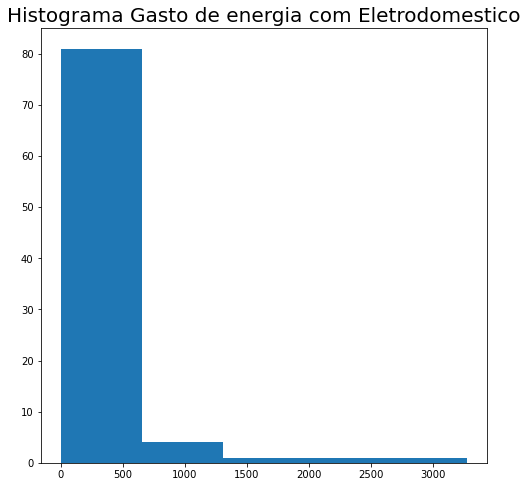

In [18]:
# Histograma do Consumo de energia dos eletrodomesticos
plt.figure(figsize=(8,8))
plt.hist(df['Appliances'].value_counts(), bins=5)
plt.title("Histograma Gasto de energia com Eletrodomestico", fontsize=20);

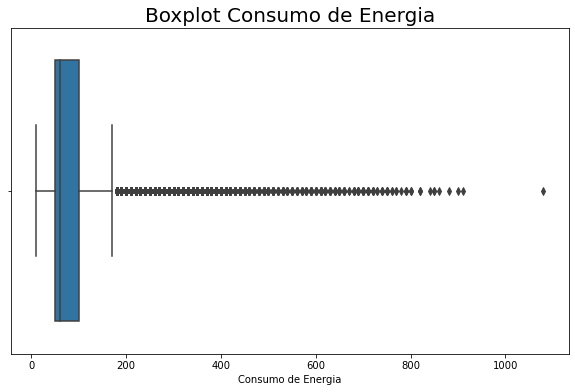

In [22]:
# BoxPlot 
plt.figure(figsize=(10,6))
sns.boxplot(x = df['Appliances'])
plt.title('Boxplot Consumo de Energia', fontsize=20)
plt.xlabel("Consumo de Energia");

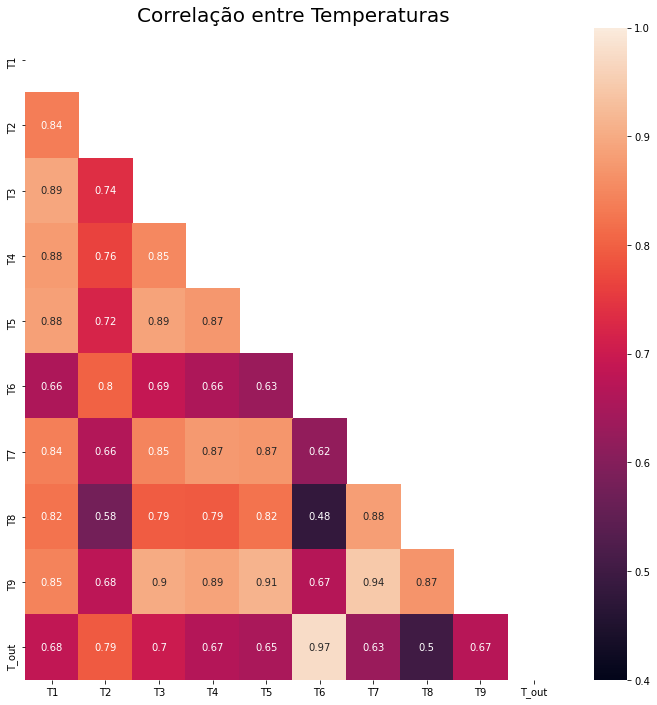

In [7]:
# Lista de temperaturas do dataset
lista_tempe = ["T" + str(i) for i in range(1, 10)]
lista_tempe.append("T_out")

# Correlação entre as medidas de temperatura
plt.figure(figsize=(12,12))
corr_tempe = df[lista_tempe].corr()
mask = np.triu(np.ones_like(corr_tempe, dtype=bool))
sns.heatmap(corr_tempe, vmin=0.4, vmax=1, annot=True, mask=mask)
plt.title("Correlação entre Temperaturas", fontsize=20);

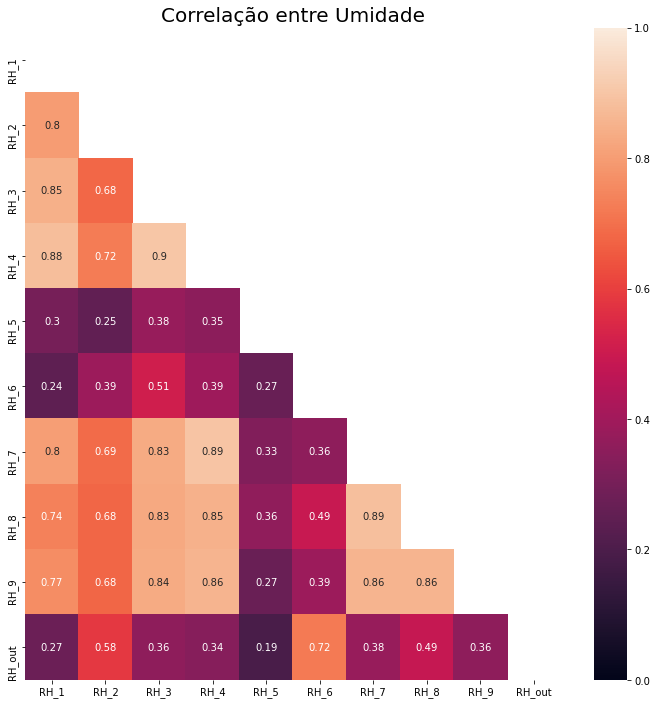

In [8]:
# Lista de Umidade do dataset
lista_umi = ["RH_" + str(i) for i in range(1, 10)]
lista_umi.append("RH_out")

# Correlação entre as medidas de temperatura
plt.figure(figsize=(12,12))
corr_umi = df[lista_umi].corr()
mask = np.triu(np.ones_like(corr_umi, dtype=bool))
sns.heatmap(corr_umi, vmin=0, vmax=1, annot=True, mask=mask)
plt.title("Correlação entre Umidade", fontsize=20);

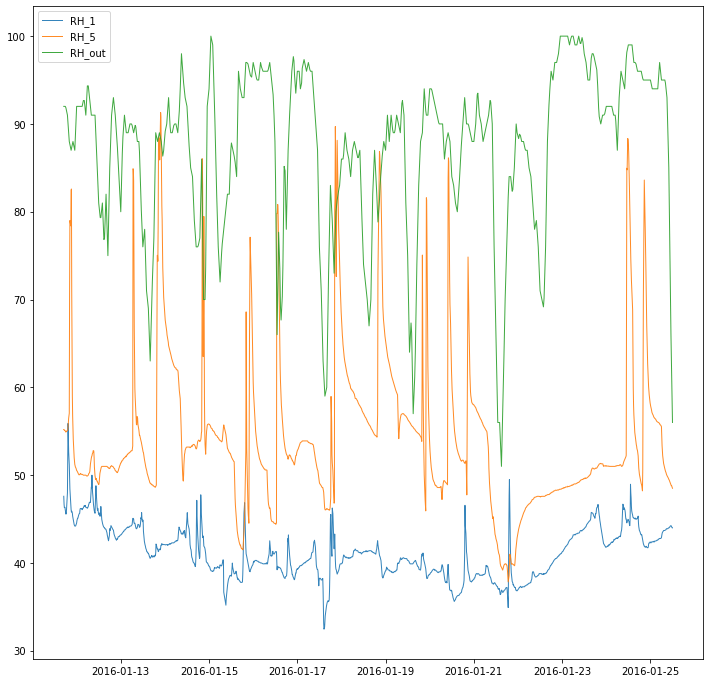

In [9]:
plt.figure(figsize=(12,12))
num=0
for column in df[["RH_1", "RH_5", "RH_out"]]:
    num+=1
    plt.plot(df['date'].iloc[:1500], df[column].iloc[:1500], marker='', linewidth=1, alpha=0.9, label=column)

plt.legend()

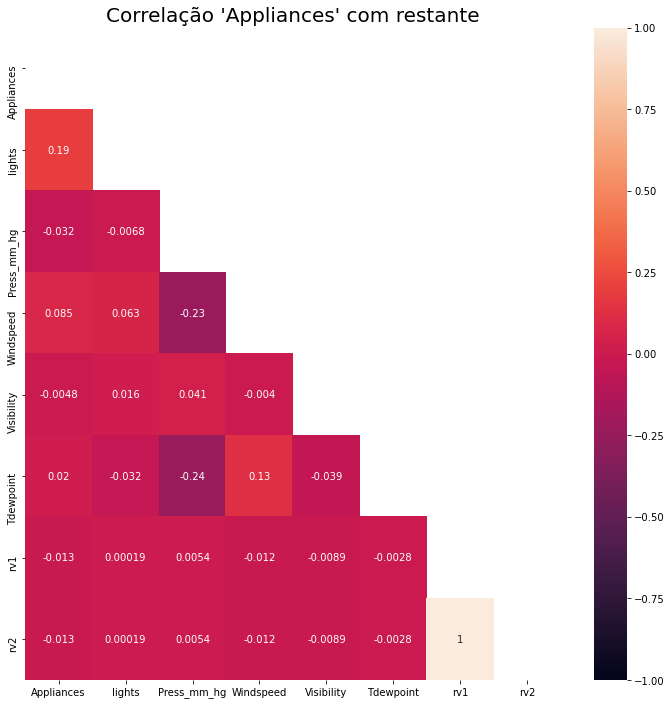

In [10]:
# Lista de variável que sobrou
lista_outrasvar = ["Appliances", "lights", "Press_mm_hg", "Windspeed", "Visibility", "Tdewpoint", "rv1", "rv2"]

# Correlação entre as medidas de temperatura
plt.figure(figsize=(12,12))
corr = df[lista_outrasvar].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask)
plt.title("Correlação 'Appliances' com restante", fontsize=20);

In [34]:
# Separando variáveis preditoras e target
y = df['Appliances']
x = df.drop(['Appliances', 'date', 'WeekStatus', 'Day_of_week'], axis=1)

In [35]:
# Separando em dados de teste e validação
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=.8, random_state=2)

#### É notável a alta correlação entre as temperaturas coletadas, e para evitar problema de multicolinearidade, irei deixar apenas a váriavel "T_out"

#### Variável "RH_out" tem correlações fortes com outras variáveis "RH", somente "RH_1" e "RH_5" apresenta comportamento diferente 

#### Baixa correlação entre variável "Appliances" e demais variáveis. E nenhuma correlação interessante entre as variáveis preditoras restante

## Algoritmos

In [ ]:

from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [60]:
# Algoritmo Regressão Logística
model_logr = LogisticRegression()

# Treinamento e predição
model_logr.fit(x_train, y_train)
y_pred = model_logr.predict(x_val)

# Métricas
rmse_logr = np.sqrt(mean_squared_error(y_val, y_pred))
mae_logr = mean_absolute_error(y_val, y_pred)

print('*'*90)
print(f'\nValor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: {rmse_logr}')
print(f'Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: {mae_logr}\n')
print('*'*90)

******************************************************************************************

Valor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: 113.66971356744905
Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: 51.10773387369132

******************************************************************************************


C:\Users\Alvim Serrao\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
# Algoritmo Regressão Support Vector Machine
model_svr = SVR()

# Treinamento e predição
model_svr.fit(x_train, y_train)
y_pred = model_svr.predict(x_val)

# Métricas
rmse_svr = np.sqrt(mean_squared_error(y_val, y_pred))
mae_svr = mean_absolute_error(y_val, y_pred)

print('*'*90)
print(f'\nValor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: {rmse_svr}')
print(f'Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: {mae_svr}\n')
print('*'*90)

******************************************************************************************

Valor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: 104.97772621912745
Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: 46.44959242431499

******************************************************************************************


In [63]:
# Algoritmo Regressão Support Vector Machine
model_gbr = GradientBoostingRegressor()

# Treinamento e predição
model_gbr.fit(x_train, y_train)
y_pred = model_gbr.predict(x_val)

# Métricas
rmse_gbr = np.sqrt(mean_squared_error(y_val, y_pred))
mae_gbr = mean_absolute_error(y_val, y_pred)

print('*'*90)
print(f'\nValor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: {rmse_gbr}')
print(f'Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: {mae_gbr}\n')
print('*'*90)

******************************************************************************************

Valor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: 88.70163553538676
Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: 47.1820693154511

******************************************************************************************


In [64]:
# Algoritmo Regressão Support Vector Machine
model_cat = CatBoostRegressor()

# Treinamento e predição
model_cat.fit(x_train, y_train)
y_pred = model_cat.predict(x_val)

# Métricas
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred))
mae_cat = mean_absolute_error(y_val, y_pred)

print('*'*90)
print(f'\nValor de RMSE (Root Mean Squared Erro) em Regressão Logística é igual: {rmse_cat}')
print(f'Valor de MAE (Mean Absolute Error) em Regressão Logística é igual: {mae_cat}\n')
print('*'*90)

Learning rate set to 0.060504
0:	learn: 101.2414650	total: 166ms	remaining: 2m 46s
1:	learn: 100.3179084	total: 187ms	remaining: 1m 33s
2:	learn: 99.4533511	total: 203ms	remaining: 1m 7s
3:	learn: 98.7275371	total: 217ms	remaining: 53.9s
4:	learn: 98.0639008	total: 229ms	remaining: 45.7s
5:	learn: 97.4912284	total: 243ms	remaining: 40.2s
6:	learn: 96.8024823	total: 256ms	remaining: 36.3s
7:	learn: 96.3071335	total: 269ms	remaining: 33.4s
8:	learn: 95.8608318	total: 283ms	remaining: 31.1s
9:	learn: 95.4015315	total: 296ms	remaining: 29.3s
10:	learn: 94.9586142	total: 309ms	remaining: 27.8s
11:	learn: 94.5725174	total: 322ms	remaining: 26.5s
12:	learn: 94.1265545	total: 335ms	remaining: 25.4s
13:	learn: 93.7553067	total: 348ms	remaining: 24.5s
14:	learn: 93.4281778	total: 362ms	remaining: 23.8s
15:	learn: 93.1200136	total: 383ms	remaining: 23.5s
16:	learn: 92.7447036	total: 402ms	remaining: 23.3s
17:	learn: 92.4333566	total: 417ms	remaining: 22.8s
18:	learn: 92.1206556	total: 431ms	remai

158:	learn: 77.7220000	total: 2.63s	remaining: 13.9s
159:	learn: 77.6491697	total: 2.66s	remaining: 14s
160:	learn: 77.6049131	total: 2.69s	remaining: 14s
161:	learn: 77.5583002	total: 2.71s	remaining: 14s
162:	learn: 77.4761232	total: 2.74s	remaining: 14.1s
163:	learn: 77.4070742	total: 2.79s	remaining: 14.2s
164:	learn: 77.2866436	total: 2.82s	remaining: 14.3s
165:	learn: 77.2389767	total: 2.85s	remaining: 14.3s
166:	learn: 77.1789652	total: 2.88s	remaining: 14.4s
167:	learn: 77.1248635	total: 2.91s	remaining: 14.4s
168:	learn: 77.0626971	total: 2.93s	remaining: 14.4s
169:	learn: 77.0141197	total: 2.95s	remaining: 14.4s
170:	learn: 76.9682340	total: 2.97s	remaining: 14.4s
171:	learn: 76.9182959	total: 2.99s	remaining: 14.4s
172:	learn: 76.8515985	total: 3.01s	remaining: 14.4s
173:	learn: 76.8243303	total: 3.03s	remaining: 14.4s
174:	learn: 76.7877749	total: 3.08s	remaining: 14.5s
175:	learn: 76.7006750	total: 3.13s	remaining: 14.6s
176:	learn: 76.6125837	total: 3.16s	remaining: 14.7s

315:	learn: 69.6553948	total: 5.96s	remaining: 12.9s
316:	learn: 69.6199548	total: 5.98s	remaining: 12.9s
317:	learn: 69.5875180	total: 6s	remaining: 12.9s
318:	learn: 69.5475260	total: 6.03s	remaining: 12.9s
319:	learn: 69.5178189	total: 6.05s	remaining: 12.9s
320:	learn: 69.4701555	total: 6.07s	remaining: 12.8s
321:	learn: 69.4359134	total: 6.09s	remaining: 12.8s
322:	learn: 69.4079718	total: 6.11s	remaining: 12.8s
323:	learn: 69.3273121	total: 6.13s	remaining: 12.8s
324:	learn: 69.2857563	total: 6.17s	remaining: 12.8s
325:	learn: 69.2648843	total: 6.2s	remaining: 12.8s
326:	learn: 69.2500587	total: 6.24s	remaining: 12.8s
327:	learn: 69.1992342	total: 6.26s	remaining: 12.8s
328:	learn: 69.1745696	total: 6.3s	remaining: 12.9s
329:	learn: 69.1613969	total: 6.33s	remaining: 12.9s
330:	learn: 69.1232295	total: 6.36s	remaining: 12.8s
331:	learn: 69.0846482	total: 6.38s	remaining: 12.8s
332:	learn: 69.0529673	total: 6.41s	remaining: 12.8s
333:	learn: 69.0337602	total: 6.42s	remaining: 12.8

472:	learn: 64.0308188	total: 9.21s	remaining: 10.3s
473:	learn: 64.0050961	total: 9.28s	remaining: 10.3s
474:	learn: 63.9838631	total: 9.3s	remaining: 10.3s
475:	learn: 63.9542719	total: 9.32s	remaining: 10.3s
476:	learn: 63.9150288	total: 9.33s	remaining: 10.2s
477:	learn: 63.8953842	total: 9.35s	remaining: 10.2s
478:	learn: 63.8739421	total: 9.36s	remaining: 10.2s
479:	learn: 63.8450614	total: 9.38s	remaining: 10.2s
480:	learn: 63.8046370	total: 9.39s	remaining: 10.1s
481:	learn: 63.7827632	total: 9.41s	remaining: 10.1s
482:	learn: 63.7670114	total: 9.42s	remaining: 10.1s
483:	learn: 63.7601865	total: 9.43s	remaining: 10.1s
484:	learn: 63.7398499	total: 9.45s	remaining: 10s
485:	learn: 63.7125021	total: 9.46s	remaining: 10s
486:	learn: 63.7012811	total: 9.47s	remaining: 9.97s
487:	learn: 63.6519299	total: 9.48s	remaining: 9.95s
488:	learn: 63.6364983	total: 9.5s	remaining: 9.93s
489:	learn: 63.6129288	total: 9.52s	remaining: 9.91s
490:	learn: 63.5513526	total: 9.54s	remaining: 9.89s

639:	learn: 59.8162629	total: 12s	remaining: 6.77s
640:	learn: 59.7912111	total: 12.1s	remaining: 6.75s
641:	learn: 59.7740965	total: 12.1s	remaining: 6.73s
642:	learn: 59.7449807	total: 12.1s	remaining: 6.71s
643:	learn: 59.7101739	total: 12.1s	remaining: 6.68s
644:	learn: 59.6837015	total: 12.1s	remaining: 6.66s
645:	learn: 59.6790774	total: 12.1s	remaining: 6.64s
646:	learn: 59.6338038	total: 12.1s	remaining: 6.62s
647:	learn: 59.5715571	total: 12.1s	remaining: 6.6s
648:	learn: 59.5502198	total: 12.2s	remaining: 6.58s
649:	learn: 59.5306514	total: 12.2s	remaining: 6.55s
650:	learn: 59.5143760	total: 12.2s	remaining: 6.53s
651:	learn: 59.4874985	total: 12.2s	remaining: 6.51s
652:	learn: 59.4637513	total: 12.2s	remaining: 6.49s
653:	learn: 59.4428215	total: 12.2s	remaining: 6.47s
654:	learn: 59.4240760	total: 12.2s	remaining: 6.45s
655:	learn: 59.4019424	total: 12.3s	remaining: 6.43s
656:	learn: 59.3757339	total: 12.3s	remaining: 6.41s
657:	learn: 59.3477995	total: 12.3s	remaining: 6.

805:	learn: 56.2074730	total: 14.4s	remaining: 3.46s
806:	learn: 56.1714257	total: 14.4s	remaining: 3.45s
807:	learn: 56.1294502	total: 14.4s	remaining: 3.43s
808:	learn: 56.0842762	total: 14.4s	remaining: 3.41s
809:	learn: 56.0796120	total: 14.5s	remaining: 3.39s
810:	learn: 56.0592378	total: 14.5s	remaining: 3.37s
811:	learn: 56.0352995	total: 14.5s	remaining: 3.36s
812:	learn: 56.0242333	total: 14.5s	remaining: 3.34s
813:	learn: 55.9970735	total: 14.5s	remaining: 3.32s
814:	learn: 55.9671713	total: 14.5s	remaining: 3.3s
815:	learn: 55.9389709	total: 14.6s	remaining: 3.28s
816:	learn: 55.9191803	total: 14.6s	remaining: 3.26s
817:	learn: 55.8997195	total: 14.6s	remaining: 3.25s
818:	learn: 55.8702828	total: 14.6s	remaining: 3.23s
819:	learn: 55.8423561	total: 14.6s	remaining: 3.21s
820:	learn: 55.8214741	total: 14.6s	remaining: 3.19s
821:	learn: 55.7935919	total: 14.6s	remaining: 3.17s
822:	learn: 55.7849174	total: 14.7s	remaining: 3.15s
823:	learn: 55.7665164	total: 14.7s	remaining: 

972:	learn: 52.7457669	total: 16.8s	remaining: 467ms
973:	learn: 52.7368875	total: 16.8s	remaining: 450ms
974:	learn: 52.7323390	total: 16.9s	remaining: 432ms
975:	learn: 52.7011711	total: 16.9s	remaining: 415ms
976:	learn: 52.6898841	total: 16.9s	remaining: 398ms
977:	learn: 52.6586403	total: 16.9s	remaining: 380ms
978:	learn: 52.6443109	total: 16.9s	remaining: 363ms
979:	learn: 52.6114254	total: 16.9s	remaining: 346ms
980:	learn: 52.5924860	total: 17s	remaining: 329ms
981:	learn: 52.5825948	total: 17s	remaining: 311ms
982:	learn: 52.5729432	total: 17s	remaining: 294ms
983:	learn: 52.5593499	total: 17s	remaining: 276ms
984:	learn: 52.5523227	total: 17s	remaining: 259ms
985:	learn: 52.5194973	total: 17s	remaining: 242ms
986:	learn: 52.4907721	total: 17s	remaining: 225ms
987:	learn: 52.4571269	total: 17.1s	remaining: 207ms
988:	learn: 52.4074337	total: 17.1s	remaining: 190ms
989:	learn: 52.3807631	total: 17.1s	remaining: 173ms
990:	learn: 52.3573383	total: 17.1s	remaining: 155ms
991:	le

In [68]:
# Tabela de comparação de métricas

dict_metricas = {"RMSE": [rmse_logr, rmse_svr, rmse_gbr, rmse_cat], "MAE": [mae_logr, mae_svr, mae_gbr, mae_cat]}

pd.DataFrame(data=dict_metricas, index=["Regressão Logística", "SVR", "Gradient Boost", "Cat Boosting"])

,RMSE,MAE
Regressão Logística,113.669714,51.107734
SVR,104.977726,46.449592
Gradient Boost,88.701636,47.182069
Cat Boosting,75.372234,38.265431


## Referências 

https://ic.unicamp.br/~reltech/PFG/2019/PFG-19-52.pdf